## E1: Support Vector Machines

1. This experiment analyzes how well support vector machines work for ASAG at the 6 class and 2 class problems.

In [1]:
import sys
sys.path.append('../')
sys.path.append('../../../')
import libs.data as data
import libs.utils as utils
import libs.stats as stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import libs.preprocessing as pp
import libs.semantics.vsm as vsm
import exp_libs.features as f
%matplotlib inline
import spacy

In [5]:
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA

In [87]:
df = data.load_dataframe('../../../datasets/final/en/asag_v2_en_filter_cat_bad.csv')
nlp_en = spacy.load('en')

2020


In [88]:
feedback = df['Feedback_Notes'].replace(np.nan, '')
#display(np.unique(feedback))
has_misspelling = feedback.str.contains('misspelling').astype(np.int)
partially_missed_concept = feedback.str.contains('partially_missed_concept').astype(np.int)
not_enough_info = feedback.str.contains('not_enough_info').astype(np.int)
missed_concept = feedback.str.contains('missed_concept').astype(np.int)
false_assertion = feedback.str.contains('false_assertion').astype(np.int)

In [91]:
# Create Features
enc = LabelBinarizer()

# Question Types
f_question_cats = df['Category_ID'].as_matrix().reshape(-1,1)
f_question_cats_oh = enc.fit_transform(f_question_cats)

one_hot = pd.get_dummies(df['Category'])
one_hot2 = pd.get_dummies(df['ID'])

def convert_to_problem_number(pn):
    vec = np.zeros(len(one_hot2.columns))
    series = pd.Series(vec, index=one_hot2.columns)
    series[pn] = 1
    df = pd.DataFrame([], columns=one_hot2.columns)
    df.loc[0] = series.as_matrix()
    return df

convert_to_problem_number(1.3)

1.1   1.2   1.3   1.5   1.6   1.7   2.1   2.2   2.3   2.4   ...   11.8  \
0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   

   11.9  12.1  12.2  12.3  12.4  12.5  12.6  12.8  12.9  
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[1 rows x 70 columns]

In [8]:
import gensim.downloader as api
model_en = api.load('fasttext-wiki-news-subwords-300')

In [92]:
pipeline_fn = vsm.create_processing_fn(nlp_en, pp.EN_STOPS)
word2word_fn = vsm.create_word_to_word_similarity_function(model_en)

In [93]:
def entailment_similarity(ma, sa):
    
    ma_ng = vsm.create_ngram_list(ma, max_n=1)
    sa_ng = vsm.create_ngram_list(sa, max_n=1)
    
    sim = vsm.entailment_similarity(ma_ng, sa_ng, sim_fn=word2word_fn, length_penalize=False)
    
    return sim

count_vec_fn = f.create_count_vectorizer_fn(tokenizer_fn=pipeline_fn, stopwords=pp.EN_STOPS, ngram_range=(1,3))


def get_entailment_similarity(ma, sa):
    
    ma_t = pipeline_fn(ma)
    sa_t = pipeline_fn(sa)
    
    return entailment_similarity(ma_t, sa_t)
    

In [85]:

def score_student_response(df, uid, student_response, points=5):
    question = df[df['ID'] == uid].iloc[0]
    
    # Model Answers
    ma1 = get_entailment_similarity(question['MA'], student_response)
    ma2 = get_entailment_similarity(question['MA2'], student_response)
    ma3 = get_entailment_similarity(question['MA3'], student_response)
    na = get_entailment_similarity(question['NA'], student_response)
    
    pos_evidence = np.max([ma1, ma2, ma3])
    neg_evidence = na
   
    cv1 = count_vec_fn(question['MA'], student_response)
    cv2 = count_vec_fn(question['MA2'], student_response)
    cv3 = count_vec_fn(question['MA3'], student_response)
    cv_na = count_vec_fn(question['NA'], student_response)
    
    pos_evidence_tokens = np.max([cv1, cv2, cv3])
    neg_evidence_tokens = cv_na
    
    sim1 = points * pos_evidence
    sim2 = points * pos_evidence_tokens
    neg1 = points * neg_evidence
    neg2 = points * neg_evidence_tokens
    raw_score = sim1 + sim2 - neg2
    print(raw_score)
    score = np.round(raw_score)
    return np.min([points, score])
    
    #results = [ma1, ma2, ma3, na, cv1, cv2, cv3, cv_na]
    #vec = pd.DataFrame(np.array([results]), columns=['MA', 'MA2', 'MA3', 'NA', 'CV1', 'CV2', 'CV3', 'CV_NA'])
    #display(vec.head())
    #mat = vec.as_matrix()
    
    # y_pred = clf.predict(mat)
    
    #return y_pred
    

print(df.iloc[0]['ID'])
print(df.iloc[0]['Prompt'])
print(df.iloc[0]['MA'])

score_student_response(df, 1.1, student_response)

1.1
 What is the role of a prototype program in problem solving? 
 To simulate the behaviour of portions of the desired software product. 


/home/che/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


1.9749731038297926


2.0

In [94]:
# Count Vectors
f_count_vec = data.load('../tmp/features/count_vec')
f_count_vec_na = data.load('../tmp/features/count_vec_na')

f_count_vec_ma2 = data.load('../tmp/features/count_vec_ma2')
f_count_vec_ma3 = data.load('../tmp/features/count_vec_ma3')

# FastText Entailments
f_ft_entailment = data.load('../tmp/features/features_fastText_entailment')
f_ft_entailment_na = data.load('../tmp/features/features_fastText_entailment_na')

f_ft_ent_ma2 = data.load('../tmp/features/features_fastText_entailment_ma2')
f_ft_ent_ma3 = data.load('../tmp/features/features_fastText_entailment_ma3')

# Edit Distances
f_token_ed = data.load('../tmp/features/token_edit_distance_MA')
f_tree_ed = data.load('../tmp/features/tree_distance_MA')
print(len(f_count_vec), len(f_count_vec_na), len(f_ft_entailment), len(f_ft_entailment_na), len(f_token_ed), len(f_tree_ed), len(f_question_cats_oh))

features = [
    f_count_vec, f_count_vec_na,
    f_ft_entailment, f_ft_entailment_na,
    utils.min_max_normalization(f_token_ed), utils.min_max_normalization(f_tree_ed),
    missed_concept, partially_missed_concept, has_misspelling, false_assertion
]

features_w_ma = features + [
    f_count_vec_ma2, f_count_vec_ma3,
    f_ft_ent_ma2, f_ft_ent_ma3
]

#features = np.array(features).reshape(len(df), 6)

cols = ['CV', 'CV_NA', 'EMD', 'EMD_NA', 'TKN_ED', 'TREE_ED', 'MConc', 'PMConc', 'SPELL', 'FAssert']

df_features = pd.DataFrame(np.array(features).T, columns=cols)
display(df_features.head(2))
true_scores = np.round(df['Score'])
dff = df_features.join(one_hot)

cols_ma = cols + ['CV_MA2', 'CV_MA3', 'EMD_MA2', 'EMD_MA3']
df_features_ma = pd.DataFrame(np.array(features_w_ma).T, columns=cols_ma)
dff_ma = df_features_ma.join(one_hot)
dff2_ma = df_features_ma.join(one_hot2)
display(dff_ma.head(2))

# PCA
info = PCA(n_components=1)

neg_evidence = info.fit_transform(df_features_ma[['CV_NA', 'EMD_NA']]).reshape((len(df),))
pos_evidence_cv = info.fit_transform(df_features_ma[['CV', 'CV_MA2', 'CV_MA3']]).reshape((len(df),))
pos_evidence_emd = info.fit_transform(df_features_ma[['EMD', 'EMD_MA2', 'EMD_MA3']]).reshape((len(df),))

dff_ma_pca = pd.DataFrame(np.array([
    pos_evidence_cv, pos_evidence_emd, neg_evidence,
    utils.min_max_normalization(f_token_ed), utils.min_max_normalization(f_tree_ed),
    missed_concept, partially_missed_concept, has_misspelling, false_assertion
]).T, columns=['CV', 'EMD', 'NEG', 'TKN_ED', 'TREE_ED', 'MConc', 'PMConc', 'SPELL', 'FAssert'])
dff_ma_pca.head(1)

2010 2010 2010 2010 2010 2010 2020


ValueError: Shape of passed values is (1, 10), indices imply (10, 10)

### 01: Support Vector Machine

1. All Features except categories

In [52]:
# clf = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(200,), random_state=1)


# print(dff2_ma.columns)

e_cols = dff2_ma.columns.tolist()
e_cols = ['EMD', 'EMD_MA2', 'EMD_MA3', 'EMD_NA', 'CV', 'CV_MA2', 'CV_MA3', 'CV_NA', 'MConc', 'SPELL']

x_train, x_test, y_train, y_test = train_test_split(dff2_ma[e_cols].as_matrix(), df['Class2_Score'], test_size=0.15, random_state=22, stratify=df['Class2_Score'])

clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

stats.print_all_stats(y_test, y_pred)
stats.plot_confusion_matrix(stats.cm(y_test, y_pred), classes=np.arange(2))

             precision    recall  f1-score   support

          0       0.70      0.56      0.62        72
          1       0.87      0.93      0.90       230

avg / total       0.83      0.84      0.83       302

Pearson's R: 0.5244867353677217
Cohen's Kappa: 0.5187642276422764
MAE: -0.04966887417218543
Accuracy: 83.77%
Precision: 82.94%
Recall: 83.77%
F1-Measure: 83.09%


In [15]:
clf = SVC(kernel='rbf')

x_train, x_test, y_train, y_test = train_test_split(dff.as_matrix(), true_scores, test_size=0.35, random_state=22, stratify=true_scores)

clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

stats.print_all_stats(y_test, y_pred)
stats.plot_confusion_matrix(stats.cm(y_test, y_pred), classes=np.arange(6))

             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00         5
        1.0       0.00      0.00      0.00         3
        2.0       0.00      0.00      0.00        82
        3.0       0.00      0.00      0.00        55
        4.0       0.43      0.43      0.43       237
        5.0       0.61      0.88      0.72       322

avg / total       0.42      0.55      0.47       704

Pearson's R: 0.3851476742221223
Cohen's Kappa: 0.22532423491632858
MAE: -0.5596590909090909
Accuracy: 54.83%
Precision: 42.31%
Recall: 54.83%
F1-Measure: 47.40%


/home/che/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/che/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/che/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Index([     'CV',   'CV_NA',     'EMD',  'EMD_NA',  'TKN_ED', 'TREE_ED',
         'MConc',  'PMConc',   'SPELL', 'FAssert',  'CV_MA2',  'CV_MA3',
       'EMD_MA2', 'EMD_MA3',       1.1,       1.2,       1.3,       1.5,
             1.6,       1.7,       2.1,       2.2,       2.3,       2.4,
             2.6,       2.7,       3.1,       3.3,       3.4,       3.5,
             3.6,       3.7,       4.1,       4.2,       4.4,       4.5,
             5.1,       5.2,       5.3,       5.4,       6.1,       6.2,
             6.3,       6.4,       6.5,       6.6,       6.7,       7.1,
             7.2,       7.3,       7.5,       7.6,       7.7,       8.1,
             8.3,       8.4,       8.5,       8.6,       8.7,       9.1,
             9.3,       9.4,       9.5,      10.1,      10.2,      10.3,
            10.4,      10.5,      10.6,      10.7,      11.1,      11.4,
            11.5,      11.7,      11.8,      11.9,      12.1,      12.2,
            12.3,      12.4,      12.5,      12.6, 

             precision    recall  f1-score   support

          0       0.69      0.66      0.67        83
          1       0.21      0.11      0.15        27
          2       0.29      0.19      0.23        57
          3       0.40      0.40      0.40       101
          4       0.50      0.53      0.52       104
          5       0.85      0.93      0.89       332

avg / total       0.64      0.67      0.66       704

Pearson's R: 0.7859078468347706
Cohen's Kappa: 0.5258708778448676
MAE: -0.171875
Accuracy: 67.05%
Precision: 64.48%
Recall: 67.05%
F1-Measure: 65.53%


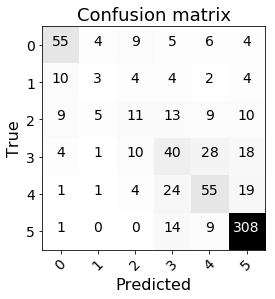

In [17]:
clf = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')

e_cols = ['CV', 'CV_NA', 'EMD', 'EMD_NA', 'TKN_ED', 'MConc', 'FAssert', 'SPELL', 'PMConc']

display(dff2_ma.columns)

x_train, x_test, y_train, y_test = train_test_split(dff2_ma.as_matrix(), df['MyScore'], 
                                                    test_size=0.35, random_state=22, stratify=df['MyScore'])

clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

stats.print_all_stats(y_test, y_pred)
stats.plot_confusion_matrix(stats.cm(y_test, y_pred), classes=np.arange(6))

['CV',
 'CV_NA',
 'EMD',
 'EMD_NA',
 'TKN_ED',
 'TREE_ED',
 'MConc',
 'PMConc',
 'SPELL',
 'FAssert',
 'CV_MA2',
 'CV_MA3',
 'EMD_MA2',
 'EMD_MA3']

CV_MA2    CV_MA3   EMD_MA2   EMD_MA3  1.1  1.2  1.3  1.5  1.6  1.7  \
0  0.109985  0.029934  0.620905  0.651079    1    0    0    0    0    0   

     ...     12.4  12.5  12.6  12.8  12.9        CV  CV_NA      EMD    EMD_NA  \
0    ...        0     0     0     0     0  0.032791    0.0  0.61447  0.532611   

    TREE_ED  
0  0.328358  

[1 rows x 79 columns]

             precision    recall  f1-score   support

          0       0.58      0.59      0.59        83
          1       0.55      0.53      0.54       129
          2       0.78      0.79      0.79       190

avg / total       0.67      0.67      0.67       402

Pearson's R: 0.6236179357348357
Cohen's Kappa: 0.4713537066478243
MAE: -0.0024875621890547263
Accuracy: 66.67%
Precision: 66.54%
Recall: 66.67%
F1-Measure: 66.60%


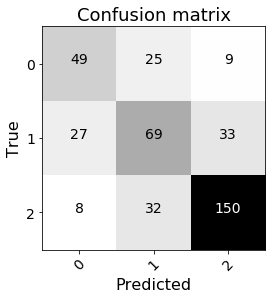

In [50]:
display(cols_ma)

# test_cols = ['CV', 'CV_NA', 'EMD', 'EMD_NA', 'TKN_ED', 'TREE_ED', 'MConc', 'PMConc', 'SPELL', 'FAssert', 'CV_MA2', 'CV_MA3', 'EMD_MA2', 'EMD_MA3']
test_cols = ['CV', 'CV_NA', 'EMD', 'EMD_NA', 'CV_MA2', 'CV_MA3', 'EMD_MA2', 'EMD_MA3', 'FAssert', 'MConc', 'PMConc', 'SPELL']

clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(200,), random_state=1)

data_tmp = dff2_ma.iloc[:, 10:].copy()
data_tmp['CV'] = dff2_ma.iloc[:, 0]
data_tmp['CV_NA'] = dff2_ma.iloc[:, 1]
data_tmp['EMD'] = dff2_ma.iloc[:, 2]
data_tmp['EMD_NA'] = dff2_ma.iloc[:, 3]
#data_tmp['TKN_ED'] = dff2_ma.iloc[:, 4]
data_tmp['TREE_ED'] = dff2_ma.iloc[:, 5]
display(data_tmp.head(1))

x_train, x_test, y_train, y_test = train_test_split(data_tmp.as_matrix(), df['Class3_Score'], test_size=0.2, random_state=22, stratify=df['Class3_Score'])

clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

stats.print_all_stats(y_test, y_pred)
stats.plot_confusion_matrix(stats.cm(y_test, y_pred), classes=np.arange(3))

In [131]:
clf = SVC(kernel='rbf')

x_train, x_test, y_train, y_test = train_test_split(dff.as_matrix(), df['Class2_Score'], test_size=0.35, random_state=22, stratify=df['Class2_Score'])

clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

stats.print_all_stats(y_test, y_pred)
stats.plot_confusion_matrix(stats.cm(y_test, y_pred), classes=np.arange(2))

             precision    recall  f1-score   support

          0       0.40      0.02      0.05       167
          1       0.77      0.99      0.86       537

avg / total       0.68      0.76      0.67       704

Pearson's R: 0.045936669414811476
Cohen's Kappa: 0.018900286967707847
MAE: -0.22301136363636365
Accuracy: 75.99%
Precision: 67.85%
Recall: 75.99%
F1-Measure: 66.88%


             precision    recall  f1-score   support

          0       0.29      0.05      0.08       146
          1       0.49      0.37      0.42       226
          2       0.57      0.87      0.69       332

avg / total       0.49      0.54      0.48       704

Pearson's R: 0.25633573684419797
Cohen's Kappa: 0.2006692960439822
MAE: -0.4247159090909091
Accuracy: 54.12%
Precision: 48.69%
Recall: 54.12%
F1-Measure: 47.82%


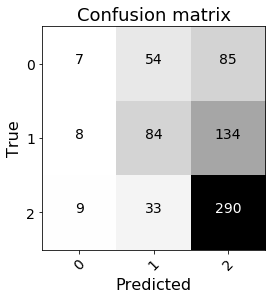

In [132]:
clf = SVC(kernel='rbf')

x_train, x_test, y_train, y_test = train_test_split(dff.as_matrix(), df['Class3_Score'], test_size=0.35, random_state=22, stratify=df['Class3_Score'])

clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

stats.print_all_stats(y_test, y_pred)
stats.plot_confusion_matrix(stats.cm(y_test, y_pred), classes=np.arange(3))

             precision    recall  f1-score   support

          0       0.80      0.34      0.47       146
          1       0.67      0.55      0.61       226
          2       0.72      0.99      0.83       332

avg / total       0.72      0.71      0.69       704

Pearson's R: 0.6564522798488126
Cohen's Kappa: 0.5147412098711509
MAE: -0.296875
Accuracy: 71.31%
Precision: 72.04%
Recall: 71.31%
F1-Measure: 68.51%


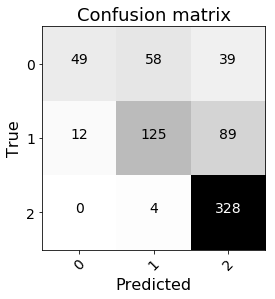

In [143]:
clf = RandomForestClassifier(n_estimators=100, max_depth=3)

x_train, x_test, y_train, y_test = train_test_split(dff.as_matrix(), df['Class3_Score'], test_size=0.35, random_state=22, stratify=df['Class3_Score'])

clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

stats.print_all_stats(y_test, y_pred)
stats.plot_confusion_matrix(stats.cm(y_test, y_pred), classes=np.arange(3))

In [151]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(150,), random_state=1)

x_train, x_test, y_train, y_test = train_test_split(dff.as_matrix(), df['Class3_Score'], test_size=0.35, random_state=22, stratify=df['Class3_Score'])

clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

stats.print_all_stats(y_test, y_pred)
stats.plot_confusion_matrix(stats.cm(y_test, y_pred), classes=np.arange(3))

             precision    recall  f1-score   support

          0       0.70      0.63      0.66       146
          1       0.73      0.56      0.63       226
          2       0.80      0.96      0.87       332

avg / total       0.76      0.76      0.75       704

Pearson's R: 0.746562487181101
Cohen's Kappa: 0.6140148132583916
MAE: -0.11789772727272728
Accuracy: 76.28%
Precision: 75.55%
Recall: 76.28%
F1-Measure: 75.15%


In [153]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(150,), random_state=1)

x_train, x_test, y_train, y_test = train_test_split(dff.as_matrix(), df['Class2_Score'], test_size=0.35, random_state=22, stratify=df['Class2_Score'])

clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

stats.print_all_stats(y_test, y_pred)
stats.plot_confusion_matrix(stats.cm(y_test, y_pred), classes=np.arange(2))

             precision    recall  f1-score   support

          0       0.72      0.63      0.67       167
          1       0.89      0.92      0.91       537

avg / total       0.85      0.85      0.85       704

Pearson's R: 0.5795615470409007
Cohen's Kappa: 0.5774063454320815
MAE: -0.029829545454545456
Accuracy: 85.37%
Precision: 84.86%
Recall: 85.37%
F1-Measure: 85.02%
